<a id='top'></a>

------

CSCI E-82 Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Section : Saturday 8th December 10AM EST

----------
  
# Dask  

Recommender Systems (in another notebook)

-------


## [Dask](#https://docs.dask.org/en/latest/)



- familiar pure python API
- for working with large datasets
- in parallel using many threads/processes/machines

Dask Interfaces
- Dask arrays - parallel numpy
- Dask Dataframe - parallel pandas
- Dask Machine Learning - parallel scikit-learn

Dask collections build dask graphs 
- Results aren't computed immediately 
- Dask's schedulers compute graphs in parallel on many threads/processes/machines

Schedulers execute task graphs
- Execute items in parallel
- Execute using many threads/process/machines


Dask ML

- delayed (lazy computations) results - call compute() to return results. [Similar to tf.session.run()]


Dask Limitations
- Still too early (Do not use if your dataset can work with plain pandas, numpy) 
- https://distributed.readthedocs.io/en/latest/limitations.html

In [1]:
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from dask.array import stats as dask_stats
#register globally
#pbar = ProgressBar()   
#pbar.register()
#pbar.unregister()

from matplotlib import pyplot as plt
%matplotlib inline

import datetime
import pandas as pd

import seaborn as sns


In [2]:
#Download dataset from - https://www.kaggle.com/new-york-city/nyc-parking-tickets

df = dd.read_csv('/Users/Rashmi/Documents/kaggle/nyc-parking-tickets/*2017.csv', 
                 usecols=['Vehicle Color', 'Issue Date','Vehicle Year'])  #reading only 3 columns

#10803029 ~10M rows 
#pandas parse_dates is slow, doesn't matter for small datasets.

#Create visualizations - heatmap of #parking tickets with month and day of week 
# - Vehicle color vs. Vehicle age - violin plot

In [3]:
print(df.columns,'\n', df.dtypes,'\n' ,df.shape)

#whenever we perform some kind of action on a Dask Delayed object, 
#we have to call the compute method before anything actually happens.


Index(['Issue Date', 'Vehicle Color', 'Vehicle Year'], dtype='object') 
 Issue Date       object
Vehicle Color    object
Vehicle Year      int64
dtype: object 
 (Delayed('int-cdbea9d4-91ac-4804-9968-bd6b608b79e5'), 3)


In [4]:
print(len(df.columns))  #fast

with ProgressBar():
    print(len(df)) #slow  #wc -l on terminal #10M samples

3
[########################################] | 100% Completed | 15.0s
10803028


In [5]:
df
#Notice column names and column types, Number of partitions = 33, Internal name of the underlying DAG = from-delayed
#Number of nodes in the underlying DAG.

,Issue Date,Vehicle Color,Vehicle Year
npartitions=33,,,
,object,object,int64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


<img src="dask.png" alt = "Dask" style = "width:800px; height=702px;">
Source: Data Science at Scale with Python and Dask, Jesse C. Daniel

In [6]:
df['Issue Date'] = dd.to_datetime(df['Issue Date'], format='%m/%d/%Y') 
with ProgressBar():
    print(df.head())

[########################################] | 100% Completed |  1.8s
  Issue Date Vehicle Color  Vehicle Year
0 2016-07-10            GY          2001
1 2016-07-08            GY          2001
2 2016-08-23            BK          2004
3 2017-06-14            WH          2007
4 2016-11-21         WHITE          2007


In [7]:
#Compute day of week and month of year from Issue Date
day_of_week = df['Issue Date'].apply(lambda x: x.strftime("%A"), meta='datetime64[ns]') 
month_of_year = df['Issue Date'].apply(lambda x: x.strftime("%B"),  meta=str)

with ProgressBar():
    day_of_week = day_of_week.compute()
    month_of_year = month_of_year.compute()

[########################################] | 100% Completed |  1min 52.5s
[########################################] | 100% Completed |  1min 52.2s


In [8]:
#following is similar to pandas concat
heatmap_data = dd.multi.concat([month_of_year,day_of_week], axis=1 ,interleave_partitions=True)
print(len(heatmap_data))
heatmap_data = heatmap_data.reset_index(drop=True)
print(type(heatmap_data))
heatmap_data.head()

10803028
<class 'dask.dataframe.core.DataFrame'>


,0,1
0,July,Sunday
1,September,Thursday
2,June,Wednesday
3,May,Wednesday
4,September,Saturday


In [9]:
heatmap_data['idx'] = heatmap_data.index
heatmap_data.columns = ['month_of_year','day_of_week','idx']
heatmap_data.head()

,month_of_year,day_of_week,idx
0,July,Sunday,0
1,September,Thursday,1
2,June,Wednesday,2
3,May,Wednesday,3
4,September,Saturday,4


In [10]:
heatmap_data = heatmap_data.categorize(["month_of_year",'day_of_week']) #dask

heatmap_data_group = heatmap_data.groupby(['day_of_week', 'month_of_year']).count().compute()
print(type(heatmap_data_group))
heatmap_data_group.head(n=20)

<class 'pandas.core.frame.DataFrame'>


idx
day_of_week month_of_year        
Sunday      July            35914
            September       34536
            June            40488
            May             38289
            February        33279
            April           47333
            March           37181
            November        34789
            December        28720
            January         33852
            August          31359
            October         43886
Thursday    July           122852
            September      212311
            June           218522
            May            156734
            February       123834
            April          148910
            March          207184
            November       135736

In [11]:
#pandas
heatmap_data_group = heatmap_data_group.reset_index()
heatmap_data_group = heatmap_data_group.pivot_table(columns='day_of_week', index='month_of_year')
heatmap_data_group.columns = heatmap_data_group.columns.droplevel()
heatmap_data_group

day_of_week,Sunday,Thursday,Wednesday,Saturday,Friday,Tuesday,Monday
month_of_year,,,,,,,
July,35914,122852,109778,84054,147109,116953,84374
September,34536,212311,154333,89482,197549,167345,105572
June,40488,218522,170374,103078,194148,213404,163386
May,38289,156734,201201,88791,151419,221836,168264
February,33279,123834,147535,90153,139773,156059,136872
April,47333,148910,135565,120131,153894,138738,144335
March,37181,207184,174187,92179,171097,122100,161319
November,34789,135736,183774,88620,147654,154447,154829
December,28720,162009,120472,76669,158986,133437,98953


In [12]:
#Ran into issue with categorical index
#https://github.com/pandas-dev/pandas/issues/19136  
index_df = heatmap_data_group.index.to_frame(index=False)
print(index_df.values.flatten())
heatmap_data_group = heatmap_data_group.reset_index(drop=True)
#merging index back
heatmap_data_group = pd.merge(index_df, heatmap_data_group, left_index=True, right_index=True)
heatmap_data_group

['July' 'September' 'June' 'May' 'February' 'April' 'March' 'November'
 'December' 'January' 'August' 'October']


,month_of_year,Sunday,Thursday,Wednesday,Saturday,Friday,Tuesday,Monday
0,July,35914,122852,109778,84054,147109,116953,84374
1,September,34536,212311,154333,89482,197549,167345,105572
2,June,40488,218522,170374,103078,194148,213404,163386
3,May,38289,156734,201201,88791,151419,221836,168264
4,February,33279,123834,147535,90153,139773,156059,136872
5,April,47333,148910,135565,120131,153894,138738,144335
6,March,37181,207184,174187,92179,171097,122100,161319
7,November,34789,135736,183774,88620,147654,154447,154829
8,December,28720,162009,120472,76669,158986,133437,98953
9,January,33852,164710,154423,78539,152490,166420,128146


In [13]:
heatmap_data_group = heatmap_data_group.reindex([9,4,6,5,3,2,0,10,1,11,7,8]).reset_index(drop=True)
heatmap_data_group = heatmap_data_group[['month_of_year','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
heatmap_data_group = heatmap_data_group.set_index('month_of_year')
heatmap_data_group

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
month_of_year,,,,,,,
January,33852,128146,166420,154423,164710,152490,78539
February,33279,136872,156059,147535,123834,139773,90153
March,37181,161319,122100,174187,207184,171097,92179
April,47333,144335,138738,135565,148910,153894,120131
May,38289,168264,221836,201201,156734,151419,88791
June,40488,163386,213404,170374,218522,194148,103078
July,35914,84374,116953,109778,122852,147109,84054
August,31359,139209,162200,147502,132329,123874,65301
September,34536,105572,167345,154333,212311,197549,89482


In [16]:
heatmap_data_group.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,36635.500000,137462.666667,159225.166667,154689.416667,162974.416667,158516.833333,90748.333333
std,5246.022103,28069.986710,32004.219065,25757.623336,33838.170331,21087.784249,15130.688126
min,28720.000000,84374.000000,116953.000000,109778.000000,122852.000000,123874.000000,65301.000000
25%,33708.750000,122502.500000,137412.750000,144517.750000,134884.250000,147517.750000,82675.250000
50%,35351.500000,141772.000000,156911.000000,154378.000000,159371.500000,153192.000000,89136.500000
75%,38838.750000,161835.750000,166651.250000,171327.250000,179717.500000,165931.000000,94903.750000
max,47333.000000,168264.000000,221836.000000,201201.000000,218522.000000,197549.000000,120131.000000


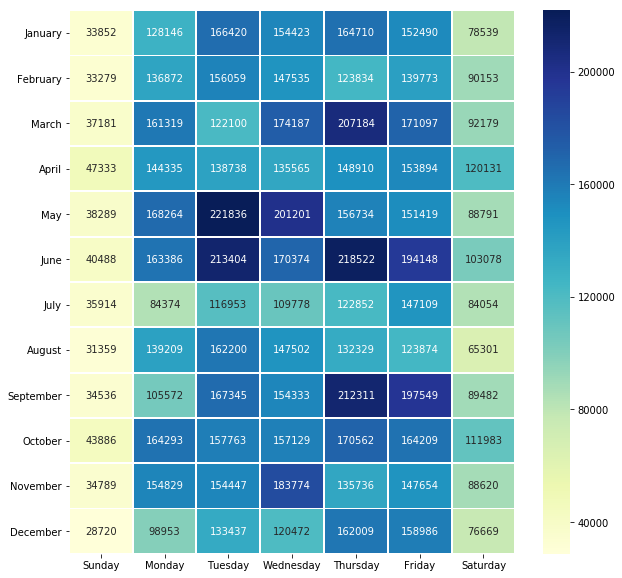

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(heatmap_data_group, annot=True, fmt="d", linewidths=1,ax=ax, cmap="YlGnBu" );
ax.set_ylabel("")
plt.show()

The heatmap immediately shows that weekends tend to see fewer citations issued than weekdays, with Sundays especially lower. We’re likely seeing the effect of fewer enforcement officers working weekend shifts. It appears that Sundays in December sees the fewest citations issued of any month/weekday combination, and Tuesdays in May seem to have the highest number of citations issued. 

Another visualization...

In [17]:
df['Vehicle Year'].value_counts().compute()

0       2320790
2015    1082841
2016    1024243
2014     719433
2013     612714
2012     484171
2007     462711
2011     417977
2006     415179
2008     400453
2005     374042
2004     348800
2010     342015
2009     319620
2017     296778
2003     287789
2002     236675
2001     195769
1999     113641
1998      86889
1997      75753
1996      41849
1995      35922
1994      15157
1990      14770
1992      13755
1993      12720
1988      12164
1989       8497
1991       6609
         ...   
2058         14
2024         14
2047         14
2056         11
2050         11
2046         11
2025         11
2022         11
2040         10
2031         10
2048          9
2028          9
2023          8
2053          8
2041          7
2045          5
2027          5
2036          5
2042          4
2037          4
2030          4
2044          4
2038          4
2035          3
2034          3
2039          3
2033          3
2043          2
2032          2
2029          1
Name: Vehicle Year, Leng

In [18]:
#Notice the anaomalies in data above, so we will filter the dataset.
with ProgressBar(): 
    condition = (df['Vehicle Year'] > 0) & (df['Vehicle Year'] <= 2018)
    vehicle_age_by_year = df[condition]['Vehicle Year'].value_counts().compute().sort_index() 

print(vehicle_age_by_year.sum())
vehicle_age_by_year

[########################################] | 100% Completed | 38.1s
8480393


1970        184
1971        286
1972        260
1973        269
1974        182
1975        236
1976        217
1977        321
1978        383
1979        482
1980        501
1981        583
1982        561
1983        789
1984       1375
1985       2091
1986       5534
1987       5063
1988      12164
1989       8497
1990      14770
1991       6609
1992      13755
1993      12720
1994      15157
1995      35922
1996      41849
1997      75753
1998      86889
1999     113641
2001     195769
2002     236675
2003     287789
2004     348800
2005     374042
2006     415179
2007     462711
2008     400453
2009     319620
2010     342015
2011     417977
2012     484171
2013     612714
2014     719433
2015    1082841
2016    1024243
2017     296778
2018       2140
Name: Vehicle Year, dtype: int64

In [20]:
nyc_data_filtered = df[condition]
age_calculation = lambda row: int(row['Issue Date'].year - row['Vehicle Year'])
vehicle_age = nyc_data_filtered.apply(age_calculation, axis=1, meta=('Vehicle Age','int'))
nyc_data_vehicle_age_stg1 = nyc_data_filtered.assign(VehicleAge=vehicle_age) 
nyc_data_vehicle_age_stg2 = nyc_data_vehicle_age_stg1.rename(columns={'VehicleAge':'Vehicle Age'})
#E nyc_data_with_vehicle_age =
nyc_data_vehicle_age_stg2[nyc_data_vehicle_age_stg2['Vehicle Age'] >= 0]
nyc_data_with_vehicle_age = nyc_data_vehicle_age_stg2[nyc_data_vehicle_age_stg2['Vehicle Age'] >= 0]

nyc_data_with_vehicle_age.head()

,Issue Date,Vehicle Color,Vehicle Year,Vehicle Age
0,2016-07-10,GY,2001,15
1,2016-07-08,GY,2001,15
2,2016-08-23,BK,2004,12
3,2017-06-14,WH,2007,10
4,2016-11-21,WHITE,2007,9


In [22]:
with ProgressBar():
    descriptive_stats = nyc_data_with_vehicle_age['Vehicle Age'].describe().compute() #B
descriptive_stats.round(2)

[########################################] | 100% Completed |  4min 31.1s


count    8425855.00
mean           6.61
std            5.70
min            0.00
25%            2.00
50%            5.00
75%           11.00
max           62.00
dtype: float64

Ticketed vehicles, on average, are about seven years old. There are some brand new vehicles (denoted by a minimum age of 0 years), and the oldest vehicle was 62 years old (outlier?) . The standard deviation of 5.7 indicates that, on average, vehicles in this dataset tend to be +/- 5.7 years from the average age of 6.61 years. Finally, there is a positive skew to the data, meaning vehicles that were newer that 6.61 years were more common than vehicles that were older than 6.61 years. 


In [23]:
with ProgressBar():
    print(nyc_data_with_vehicle_age['Vehicle Color'].value_counts().compute())

GY       1690578
WH       1629283
BK       1468740
BL        577756
WHITE     557628
RD        371184
BLACK     247043
BROWN     239103
GR        186406
GREY      129958
TN        126067
BLUE      107560
SILVE     103045
RED        94372
YW         88229
BR         82686
BLK        66862
GL         53046
GRAY       49450
MR         34228
OTHER      33560
GRY        32986
GREEN      32610
WT         22593
TAN        19616
WHT        17884
YELLO      17539
OR         16285
WHI        15011
GOLD       14496
          ...   
MAROP          1
MARUE          1
MAUVE          1
MELLO          1
M              1
MERC           1
MERL           1
METOR          1
MGY            1
MIAN           1
MINT           1
M/C            1
LY GY          1
LGTBL          1
LLOW           1
LGY            1
LI GY          1
LIGH           1
LIMEG          1
LINC           1
LITEB          1
LT BN          1
LVER           1
LT'GR          1
LT-BR          1
LT/GR          1
LTBN           1
LTGRN         

In [25]:
#filtering for common colors
row_filter = nyc_data_with_vehicle_age['Vehicle Color'].isin(['BLACK','WHITE','GREY','RED','GREEN','BLUE'])
column_filter = ['Vehicle Age','Vehicle Color']
ages_and_colors = nyc_data_with_vehicle_age[row_filter][column_filter]

with ProgressBar():
    print(len(ages_and_colors))

1169171

[########################################] | 100% Completed |  4min 22.4s


/Users/Rashmi/anaconda3/envs/ComputerVision/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


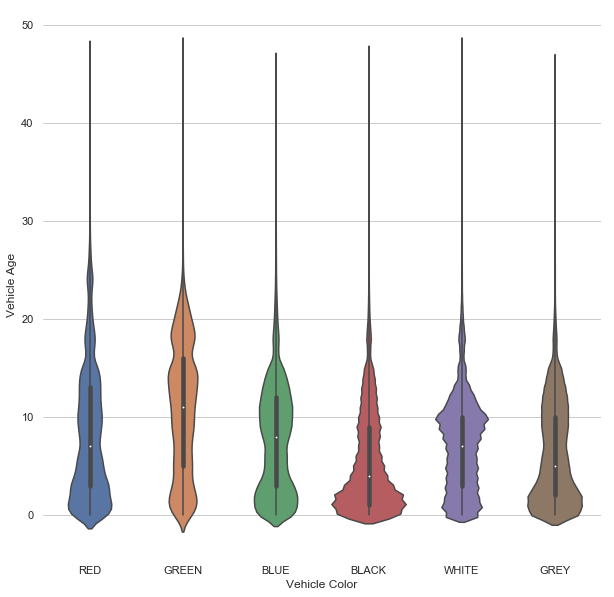

In [26]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)

group_order = ["RED", "GREEN", "BLUE", "BLACK", "WHITE", "GREY"]
with ProgressBar():
    sns.violinplot(x = "Vehicle Color", y='Vehicle Age', data=ages_and_colors.compute(), ax=ax, order=group_order)
 

Black vehicles tend to be newer, green vehicles tend to be older, and there are more red and green older vehicles on the road than other colors. All vehicle colors have roughly the same maximum age, but there are more instances of old red and green vehicles than other colors, which is denoted by a thicker line in the upper regions of the red and green plots.

**References**

https://docs.dask.org/en/latest/

Data Science at Scale with Python and Dask  - Jesse C. Daniel

https://www.youtube.com/watch?v=ccfsbuqsjgI

https://www.analyticsvidhya.com/blog/2018/08/dask-big-datasets-machine_learning-python/

----

Dask Performance tips - http://docs.dask.org/en/latest/dataframe-performance.html 

Example on my GitHub - Extracting image features using dask (used on about 100GB dataset) - https://github.com/rashmibanthia/Avito/blob/master/image_features_dask.ipynb